In [7]:
# !pip install SimpleITK
# !pip install pyradiomics

In [8]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import time
import SimpleITK as sitk
from matplotlib.pyplot import cm
from skimage import measure
from skimage.measure import regionprops
from radiomics import featureextractor
import six
import csv
import glob
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pd.set_option('display.max_columns', 50)

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Uni/Sem 8 - Spring 21/EBME 461 - Biomedical Image Processing and Analysis/Project')

### Reading in the sample data

In [39]:
# Reading the prostate mask and lesion annotation
img = sitk.ReadImage('T2W.nii.gz')
pm = sitk.ReadImage("PM.nii.gz")
ls = sitk.ReadImage("LS1.nii.gz")

In [12]:
# pyradiomics feature extractor requires some initial parameters to be set
params = {}
params['normalize'] = True
params['binWidth'] = 256
params['verbose'] = True

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**params) 

featureVector = extractor.execute(img, pm)
print(list(featureVector.keys()))
for featureName in featureVector.keys():
    print(f"Computed {featureName}: {featureVector[featureName]}")

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'origin

### Getting the data

In [ ]:
prostate_path = 'J:/Assignments/image_project/prostate_data'
fieldnames = ['patient_id','Lesion','fid']
fieldnames.extend(list(featureVector.keys()))
# print(fieldnames)
with open('features_updated.csv', mode='w', newline='') as features:
    writer = csv.DictWriter(features, fieldnames = fieldnames)
    writer.writeheader()
    for subdir, dirs, files in os.walk(prostate_path):
        subpath = subdir.split('/')
        if subpath[-1] not in 'prostate_data':
            patient_name = os.path.basename(subdir)
            print(patient_name)
            ls_files = [[file[2], sitk.ReadImage(subdir + '/'+ file)] for file in files if 'LS' in file]
            t2w = sitk.ReadImage(subdir + '/T2W.nii.gz')
            featVecLs = [[ls_no,extractor.execute(t2w, lsf)] for ls_no, lsf in ls_files]
            for ls_no, featvec in featVecLs:
                featvec['patient_id'] = patient_name
                featvec['Lesion'] = 'ls'+str(ls_no)
                featvec['fid'] = ls_no
                writer.writerow(featvec)


### Defining the Target variable

In [13]:
# Findings
findings = pd.read_csv('ProstateX-Findings-Train.csv')
features = pd.read_csv('features_updated.csv')

# fe = features.groupby('patient_id')['Lesion'].count().reset_index()
# fi = findings.groupby('ProxID')['fid'].count().reset_index()
# fefi = pd.merge(fe,fi,left_on='patient_id',right_on = 'ProxID' ,how='left')
# unbalanced = fefi[fefi['Lesion'] != fefi['fid']]

# Combined finidings with features. Added target variable
final_set = pd.merge(features,findings,left_on=['patient_id','fid'],right_on = ['ProxID','fid'] ,how='left')
final_set[["ClinSig"]] *= 1
final_set

# Selecting numerical features
init_features = final_set[['patient_id','Lesion','ClinSig']]
train_set = pd.concat([init_features, final_set.select_dtypes('float')], axis=1)
train_set = train_set[~pd.isnull(train_set['ClinSig'])]
train_set['ClinSig'] = train_set['ClinSig'].astype(np.int64)
train_set

numerical_features = train_set[train_set.columns.difference(['patient_id','Lesion','ClinSig'])]
numerical_features

,patient_id,Lesion,fid,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,...,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,ProxID,pos,zone,ClinSig
0,ProstateX-0000,ls1,1,v3.0.1,1.19.5,2.0.2,1.1.1,3.6.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6ca828fd5843ea62d8e6e412091e9749b2ab60b3,3D,"(0.5, 0.5, 3.000002145767212)","(384, 384, 19)",236.256123,0.0,962.0,585f82cf76cfc5d615dcd1618c94d3d73c2c5e95,"(0.5, 0.5, 3.000002145767212)","(384, 384, 19)","(162, 215, 8, 11, 19, 2)",240,1,"(167.275, 224.8125, 8.575)","(25.96109451888725, 32.38231838713426, -38.435...",...,2.500000,0.625000,0.187500,1.750000,7958.500000,28875.250000,2729.312500,0.812500,1.000000,0.250000,0.252574,0.252601,0.252567,2.000000e+00,0.016667,4358.500000,20.609401,0.022309,0.373545,0.078767,0.022392,ProstateX-0000,25.7457 31.8707 -38.511,PZ,1
1,ProstateX-0001,ls1,1,v3.0.1,1.19.5,2.0.2,1.1.1,3.6.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7beb013989f26eef7bd102953e0b558dc10743e6,3D,"(0.5, 0.5, 2.9999988079071045)","(384, 384, 19)",315.949401,0.0,781.0,0fda1b714f7469ee78e9d59bb1bd05d21189cdd1,"(0.5, 0.5, 2.9999988079071045)","(384, 384, 19)","(161, 174, 9, 25, 27, 3)",406,1,"(170.1206896551724, 189.77093596059115, 10.100...","(-33.89496217953199, 31.797940633156728, -13.6...",...,1.000000,1.000000,0.000000,1.000000,164836.000000,164836.000000,164836.000000,1.000000,1.000000,1.000000,0.000006,0.000006,0.000006,-3.203427e-16,0.002463,0.000000,0.000000,1000000.000000,0.000000,0.000000,0.000000,ProstateX-0001,-40.5367071921656 29.320722668457 -16.70766907...,AS,0
2,ProstateX-0002,ls1,1,v3.0.1,1.19.5,2.0.2,1.1.1,3.6.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},cd96763ed4751d11f459fcf9cb3134b75bea040f,3D,"(0.5, 0.5, 3.0000033378601074)","(384, 384, 19)",203.629306,0.0,904.0,534d360b1037f25d208e6e5d0781d20e85da1de9,"(0.5, 0.5, 3.0000033378601074)","(384, 384, 19)","(157, 211, 11, 18, 14, 2)",244,1,"(166.45901639344262, 216.80737704918033, 11.50...","(-20.304106916105624, 41.21957681464173, -27.4...",...,5.285714,0.755102,0.122449,3.571429,6716.000000,6868.571429,6677.857143,0.357143,1.857143,0.265306,0.470444,1.881767,0.117613,2.128085e+00,0.028689,5500.979592,9.140175,0.083423,0.098255,0.011050,0.075356,ProstateX-0002,-27.0102 41.5467 -26.0469,PZ,1
3,ProstateX-0002,ls2,2,v3.0.1,1.19.5,2.0.2,1.1.1,3.6.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},cd96763ed4751d11f459fcf9cb3134b75bea040f,3D,"(0.5, 0.5, 3.0000033378601074)","(384, 384, 19)",203.629306,0.0,904.0,7eec0835629229f08d8018c9581782b60

### Dropping higly correlated attributes

In [15]:
df = numerical_features.copy()
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df.drop(to_drop, axis=1, inplace=True)

### Standardization and Scaling

In [16]:
# Mormalizing features using scikit-learn StandardScaler
scaler = StandardScaler()
scaledFeatures = scaler.fit_transform(df.values)

# Scaling features between 0 and 1. 
scaler2 = MinMaxScaler()
scaled2Features = scaler2.fit_transform(scaledFeatures)

### Feature Selection

In [17]:
selector = SelectKBest(chi2, k=10)

labels = train_set.pop('ClinSig')
selectedFeatures = selector.fit_transform(scaled2Features,labels)

print(f"Number of features before feature selection: {scaledFeatures.shape[1]}")
print(f"Number of features after feature selection: {selectedFeatures.shape[1]}")

Number of features before feature selection: 66
Number of features after feature selection: 10


### Dataset split

In [25]:
# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [34]:
X,y  = selectedFeatures, labels
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

### MRMR selection

In [13]:
f = df[df.columns[0:40]]

In [18]:
import pymrmr
pymrmr.mRMR(f, 'MIQ', 20)

### 3-fold CV with Logistic Regression 

In [37]:
def evaluate_model(X, y, repeats):
    cv = RepeatedKFold(n_splits=3, n_repeats=repeats, random_state=1)
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

repeats = range(1,20)
results = list()
for r in repeats:
    scores = evaluate_model(X, y, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    results.append(scores)


>1 mean=0.7716 se=0.011
>2 mean=0.7716 se=0.008
>3 mean=0.7716 se=0.006
>4 mean=0.7716 se=0.007
>5 mean=0.7710 se=0.006
>6 mean=0.7711 se=0.006
>7 mean=0.7712 se=0.005
>8 mean=0.7712 se=0.005
>9 mean=0.7716 se=0.006
>10 mean=0.7722 se=0.005
>11 mean=0.7722 se=0.005
>12 mean=0.7726 se=0.006
>13 mean=0.7723 se=0.005
>14 mean=0.7725 se=0.005
>15 mean=0.7726 se=0.005
>16 mean=0.7726 se=0.005
>17 mean=0.7725 se=0.005
>18 mean=0.7725 se=0.005
>19 mean=0.7724 se=0.005


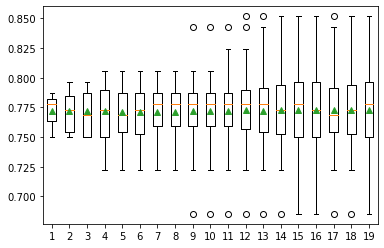

In [38]:
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()